# Исследование надёжности заёмщиков
- Задача - определить, влияет ли семейное положение, количество детей, доход и цель получения кредита на факт погашения кредита в срок.
- Входные данные от банка — статистика о платёжеспособности клиентов.
- Результаты исследования предназначены для дальнейшего использования при построении модели кредитного скоринга.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

from pymystem3 import Mystem

from google.colab import drive
drive.mount('/content/drive')

from tqdm import tqdm
from collections import Counter

Mounted at /content/drive


## Обзор данных

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Practicum_projects/\
Borrower_Reliability/data.csv')

In [3]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Выведем на экран уникальные значения столбцов с категориальными данными и посмотрим есть ли там аномальные значения.

In [5]:
columns_to_check = ['children', 'dob_years', 'education', 'education_id', 
                    'family_status', 'family_status_id', 'gender', 
                    'income_type', 'debt', 'purpose']
for col in columns_to_check:
    display(df[col].unique())

array([ 1,  0,  3,  2, -1,  4, 20,  5])

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

array([0, 1, 2, 3, 4])

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

array([0, 1, 2, 3, 4])

array(['F', 'M', 'XNA'], dtype=object)

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

array([0, 1])

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

### Вывод

В таблице 12 столбцов. Типы данных `int`, `float` и `object`.

Согласно документации:
- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел ли задолженность по возврату кредитов
- `total_income` — ежемесячный доход в рублях
- `purpose` — цель получения кредита

Стилистических ошибок в названиях колонок нет.

Всего 21525 строк, но в двух стобцах(`days_employed`, `total_income`) значиния отличаются. Это пропуски,  котрые нужно обработать.

После вывода уникальных значений столбцов с категориальными данными стали заметны некоторые проблемы:
- в столбце `children` у кого-то -1 ребёнок, а у кого-то их целых 20 (вряд ли это те самые ребята из книги рекордов Гиннесса). Скорее всего это ошибка ввода, возьмём модуль и заменим 20 на 2.
- в столбце `education` явное наличие одинаковых значений, записанных разным способом. Достаточно будет привести все значения к нижнему регистру. Сделаем это сразу перед очисткой датасета от дубликатов.
- в столбце `family_status` категория "Не женат / не замужем" единственная записана с большой буквы. Приведём к нижнему регистру из эстетических соображений.
- в столбце `gender` присутствуют пропуски, которые записаны как "XNA". Эти данные не являются типом `NaN` и никак не повлияют на ход исследования, оставим как есть.

Кроме того, в выводе `df.head()` видно что артефакты присутствуют и в столбцах с колличественными значениями:
- Значения трудового стажа(`days_employed`) во многих строках отрицательные. Думаю это ошибка вычислений и нам просто нужно взять модуль числа.
- Также видно, что в некоторых строках (напр. "пенсионеры") трудовой стаж заявителей - сотни лет. Скорее всего, причина в том, что трудовой стаж указали не в днях, а в часах.


## Предобработка данных

Обработаем основные артефакты. Возьмём модуль `children` и заменим 20 на 2.

In [6]:
df['children'] = abs(df['children'])

In [7]:
df['children'] = df['children'].replace(20, 2)
df['children'].unique()

array([1, 0, 3, 2, 4, 5])

Отлично! Теперь приведём к нижнему регистру столбец `family_status`.

In [8]:
df['family_status'] = df['family_status'].str.lower()
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

Восхитительно! Возьмём модуль колонки `days_employed`.

In [9]:
df['days_employed'] = abs(df['days_employed'])
df['days_employed'].min()

24.14163324048118

Супер, мы избавились почти от всех артефактов в таблице. Теперь можно переходить к обработке остальных.

Создадим таблицу с медианными значениям по типу занятости для колонок `days_employed`, `total_income`, `dob_years`

In [10]:
df_median = df.groupby('income_type').agg({'days_employed': 'median',\
  'total_income': 'median', 'dob_years': 'median'})

In [11]:
df_median

,days_employed,total_income,dob_years
income_type,,,
безработный,366413.652744,131339.751676,38.0
в декрете,3296.759962,53829.130729,39.0
госслужащий,2689.368353,150447.935283,40.0
компаньон,1547.382223,172357.950966,39.0
пенсионер,365213.306266,118514.486412,60.0
предприниматель,520.848083,499163.144947,42.5
сотрудник,1574.202821,142594.396847,39.0
студент,578.751554,98201.625314,22.0


Заполним нулевые значения возраста в таблице медианным значением по типу занятости, данные возьмём из таблицы `df_median`

In [12]:
for income_type in df_median.index:
    df.loc[(df['income_type'] == income_type) & (df['dob_years'] == 0),\
           'dob_years']= df_median.loc[income_type, 'dob_years'] 

Проверим результат: выведем возраст самого молодого заявителя.

In [13]:
df['dob_years'].min()

19.0

Отлично! Поправим ошибку в днях работы. Для этого найдём всех заявителей у которых трудовой стаж превышает возраст и разделим на 24, тем самым приведём данные к нужному виду.

In [14]:
df.loc[df['days_employed'] > df['dob_years'] * 365, 'days_employed'] =\
 df.loc[df['days_employed'] > df['dob_years'] * 365, 'days_employed'] / 24

### Обработка пропусков

In [15]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Значения в стобцах `days_employed`, `total_income` отличаются на равную величину, это колличественые переменные. Посмотрим на них поближе. Для этого создадим новую таблицу со всеми пропущенными значениями.

In [16]:
df[df['days_employed'].isna() == True].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65.0,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41.0,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63.0,среднее,1,не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50.0,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54.0,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


Думаю, эти пропуски обусловлены тем, что заявитель не захотел раскрывать информацию о себе или он не имеет стажа/дохода. Их нужно заполнить характерными значениями. Cтроки с пропускми заполним медианным значением по типу занятости.

Пройдёмся циклом по каждой колонке с пропусками (`columns_to_replace`) и по каждому типу занятости из таблицы `df_median`

In [17]:
columns_to_replace = ['days_employed', 'total_income']

In [18]:
for col in columns_to_replace:
    for income_type in df_median.index:
        df.loc[df['income_type'] == income_type, col] = df \
          .loc[df['income_type'] == income_type, col] \
          .fillna(df_median.loc[income_type, col])   

Проверим наличие пропусков после замены.

In [19]:
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Все пропуски в данных устранены.

### Замена типа данных

Теперь нам нужно изменить вещественный тип данных на целочисленный. Столбцы с типом данных `float`: `days_employed` и `total_income`.
Подходящий способ для такого преобразования: `astype()`.
Столбцы с подлежащими замене данными уже лежат в переменной `columns_to_replace`, осталось написать цикл.

In [20]:
columns_to_replace = ['days_employed', 'total_income']
for col in columns_to_replace:
    df[col] = df[col].astype('int')

Проверим.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  int64  
 2   dob_years         21525 non-null  float64
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  int64  
 11  purpose           21525 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


Тип данных успешно преобразован методом `astype()`.

### Обработка дубликатов

Взглянем на значения `education`, на этот раз отсортированные.

In [22]:
sorted(df['education'].unique())

['ВЫСШЕЕ',
 'Высшее',
 'НАЧАЛЬНОЕ',
 'НЕОКОНЧЕННОЕ ВЫСШЕЕ',
 'Начальное',
 'Неоконченное высшее',
 'СРЕДНЕЕ',
 'Среднее',
 'УЧЕНАЯ СТЕПЕНЬ',
 'Ученая степень',
 'высшее',
 'начальное',
 'неоконченное высшее',
 'среднее',
 'ученая степень']

В столбце `education` явное наличие одинаковых значений, записанных разным способом, исправим это. Достаточно будет привести все значения к нижнему регистру.

In [23]:
df['education'] = df['education'].str.lower()
sorted(df['education'].unique())

['высшее', 'начальное', 'неоконченное высшее', 'среднее', 'ученая степень']

Отлично!Теперь посчитаем количество явных дубликатов в таблице

In [24]:
df.duplicated().sum()

71

Обнаружен 71 дубликат. Избавимся от них методом `drop_duplicates()`

In [25]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Мы успешно избавились от всех дубликатов одним махом, заранее отыскав неявные. Дубликаты могли появиться в результате повторного заявления или потому что сотрудник банка по ошибке ввёл заявление в базу дважды.

### Лемматизация

In [26]:
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


Посмотрим ещё раз на уникальные значения в столбце `purpose`, отсортируем.

In [27]:
sorted(df['purpose'].unique())

['автомобили',
 'автомобиль',
 'высшее образование',
 'дополнительное образование',
 'жилье',
 'заняться высшим образованием',
 'заняться образованием',
 'на покупку автомобиля',
 'на покупку подержанного автомобиля',
 'на покупку своего автомобиля',
 'на проведение свадьбы',
 'недвижимость',
 'образование',
 'операции с жильем',
 'операции с коммерческой недвижимостью',
 'операции с недвижимостью',
 'операции со своей недвижимостью',
 'покупка жилой недвижимости',
 'покупка жилья',
 'покупка жилья для сдачи',
 'покупка жилья для семьи',
 'покупка коммерческой недвижимости',
 'покупка недвижимости',
 'покупка своего жилья',
 'получение высшего образования',
 'получение дополнительного образования',
 'получение образования',
 'приобретение автомобиля',
 'профильное образование',
 'ремонт жилью',
 'свадьба',
 'свой автомобиль',
 'сделка с автомобилем',
 'сделка с подержанным автомобилем',
 'строительство жилой недвижимости',
 'строительство недвижимости',
 'строительство собственной недв

Давайте лемматизируем столбец `purpose`. Лемматизацию проведём с помощью метода `Mystem()` из библиотеки `pymystem3` она приведёт все слова к единому виду и выведет в список. Создадим цикл который пройдётся по всем строкам, соединим вывод метода `Mystem()` метедом `.join()` и запишем лемматизированные строки в новый столбец `purpose_lemmas`

In [28]:
for index in tqdm(range(len(df['purpose']))):
    lemmas = ' '.join(m.lemmatize(df.loc[index,'purpose']))
    df.loc[index,'purpose_lemmas'] = lemmas

100%|██████████| 21454/21454 [00:26<00:00, 799.14it/s]


Проверим результат.

In [29]:
sorted(df['purpose_lemmas'].unique())

['автомобиль \n',
 'высокий   образование \n',
 'дополнительный   образование \n',
 'жилье \n',
 'заниматься   высокий   образование \n',
 'заниматься   образование \n',
 'на   покупка   автомобиль \n',
 'на   покупка   подержать   автомобиль \n',
 'на   покупка   свой   автомобиль \n',
 'на   проведение   свадьба \n',
 'недвижимость \n',
 'образование \n',
 'операция   с   жилье \n',
 'операция   с   коммерческий   недвижимость \n',
 'операция   с   недвижимость \n',
 'операция   со   свой   недвижимость \n',
 'покупка   жилой   недвижимость \n',
 'покупка   жилье \n',
 'покупка   жилье   для   сдача \n',
 'покупка   жилье   для   семья \n',
 'покупка   коммерческий   недвижимость \n',
 'покупка   недвижимость \n',
 'покупка   свой   жилье \n',
 'получение   высокий   образование \n',
 'получение   дополнительный   образование \n',
 'получение   образование \n',
 'приобретение   автомобиль \n',
 'профильный   образование \n',
 'ремонт   жилье \n',
 'свадьба \n',
 'свой   автомобиль \n

Давайте определим группы методом поиска наиболее встречающихся слов.

In [30]:
joined_lemmas = ' '.join(df['purpose_lemmas']).split()

In [31]:
Counter(joined_lemmas).most_common(10)

[('недвижимость', 6351),
 ('покупка', 5897),
 ('жилье', 4460),
 ('автомобиль', 4306),
 ('образование', 4013),
 ('с', 2918),
 ('операция', 2604),
 ('свадьба', 2324),
 ('свой', 2230),
 ('на', 2222)]

Из списка мы можем выделить несколько групп: "автомобиль", "образование", "жилье"/"недвижимость" и "свадьба".
Эта информация пригодится нам дальше для группировки данных.

In [32]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas
0,1,8437,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,покупка жилье \n
1,1,4024,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,приобретение автомобиль \n
2,0,5623,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,покупка жилье \n
3,3,4124,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,дополнительный образование \n
4,0,14177,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,сыграть свадьба \n


Мы успешно лемматизировали данные в столбце `purpose` с помощью `Mystem()`. Лемматизированные данные будут необходимы нам далее для ответа на вопрос "Как разные цели кредита влияют на его возврат в срок?"

### Категоризация данных

#### Цель получения кредита

Добавим столбец с категорией назначения кредита в основную таблицу. Для этого создадим функцию с обработкой ошибок.

Ранее мы выделили из списка несколько групп: "автомобиль", "образование", "жилье"/"недвижимость" и "свадьба".

In [33]:
def purpose_group(purpose):
    try:
        if 'автомобиль' in purpose:
            return 'автомобиль'
        elif 'образование' in purpose:
            return 'образование'
        elif 'жилье' in purpose or 'недвижимость' in purpose:
            return 'жилье/недвижимость'
        elif 'свадьба' in purpose:
            return 'свадьба'
        else:
            return 'другое'
    except:
        return 'error'

Применим функцию к столбцу `purpose_lemmas` и сохраним результат в столбце `purpose_group`

In [34]:
df['purpose_group'] = df['purpose_lemmas'].apply(purpose_group)

Проверим результат

In [35]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas,purpose_group
0,1,8437,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,покупка жилье \n,жилье/недвижимость
1,1,4024,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,приобретение автомобиль \n,автомобиль
2,0,5623,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,покупка жилье \n,жилье/недвижимость
3,3,4124,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,дополнительный образование \n,образование
4,0,14177,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,сыграть свадьба \n,свадьба


In [36]:
df['purpose_group'].value_counts()

жилье/недвижимость    10811
автомобиль             4306
образование            4013
свадьба                2324
Name: purpose_group, dtype: int64

Ошибок в категориях нет. Мы успешно создали ключевое слово для каждого заявления.

#### Дети

Теперь взглянем на распределение кол-ва детей среди заявителей.

In [37]:
df[['children', 'debt']].groupby('children').count()

,debt
children,
0,14091
1,4855
2,2128
3,330
4,41
5,9


Почти две трети заявителей без детей. Подобрать группы будет сложно, так как распределение будет не равным. Для достижения максимально возможной достоверности определим три группы:
- `0` - Люди не имеющие детей
- `1` - Люди с одним ребёнком в семье
- `2` - Люди у которых 2 ребёнка и более
Внесём группы в таблицу и посмотрим на распределение.

Напишем функцию с обработкой ошибок...

In [38]:
def children_group(children):
    try:
        if children == 0:
            return 0
        elif children == 1:
            return 1
        elif children >= 2:
            return 2
        else:
            return 'error'
    except:
        return 'error'

... и применим к стобцу `children`.

In [39]:
df['children_group'] = df['children'].apply(children_group)

Посмотрим на новый столбец `children_group` в таблице

In [40]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas,purpose_group,children_group
0,1,8437,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,покупка жилье \n,жилье/недвижимость,1
1,1,4024,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,приобретение автомобиль \n,автомобиль,1
2,0,5623,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,покупка жилье \n,жилье/недвижимость,0
3,3,4124,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,дополнительный образование \n,образование,2
4,0,14177,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,сыграть свадьба \n,свадьба,0


Выведем на экран распределение по группам

In [41]:
df['children_group'].value_counts()

0    14091
1     4855
2     2508
Name: children_group, dtype: int64

Распределение далеко не идеальное. Меньшее значение из трёх групп составляет почти что одну пятую от значения самой большой. Выводы, полученные с помощью такой группировки будут вызывать сомнения.

#### Деньги

Разобьём доходы на 5 групп методом `pd.qcut()`, для этого создадим колонку `income_group_raw`

In [42]:
df['income_group_raw'] = pd.qcut(df['total_income'],5,duplicates='drop')

Посмотрим на результат.

In [43]:
df.groupby('income_group_raw')['debt'].agg(['count']).sort_values(by='income_group_raw')

,count
income_group_raw,
"(20666.999, 98537.6]",4291
"(98537.6, 132134.4]",4291
"(132134.4, 161335.0]",4290
"(161335.0, 214618.2]",4291
"(214618.2, 2265604.0]",4291


`qcut` справился и разбил нам столбец `total_income` на 5 почти идеально равных столбцов. Смущают сами интервалы, попробуем выровнять. Посмотрим на распределение на интервалах: `0`: `20000 - 100000`,`1`: `100000 - 140000`,`2`: `140000 -160000`,`3`: `160000 - 220000`,`4`: `220000 - 2300000`. Для этого создадим функцию с обработкой ошибок и пременим её к столбцу `total_income`, а данные сохраним в столбец `income_group`.

In [44]:
def income_group(income):
    try:
        if 20000 < income <= 100000:
            return 0
        elif 100000 < income <= 140000:
            return 1
        elif 140000 < income <= 160000:
            return 2
        elif 160000 < income <= 220000:
            return 3
        elif 220000 < income <= 2300000:
            return 4    
        else:
            return 'error'
    except:
        return 'error'

In [45]:
df['income_group'] = df['total_income'].apply(income_group)

In [46]:
df.groupby('income_group')['debt'].agg(['count']).sort_values(by='income_group')

,count
income_group,
0,4463
1,5028
2,3243
3,4712
4,4008


Восхитительно! Отличия в количестве заявителей не критичны, а сами интервалы красивые и без долей.

Мы провели категоризацию для детей, денег и целей получения кредита. Процент должников в зависимости от семейного положения мы получим и так, ведь данные уже категоризированы. Можно приступать к финальным вычеслениям и выводам.

## Анализ

Для помощи в интерпретации полученных метрик мы введём переменную `total_debt` отражающую средний процент должников среди всех заявителей.

In [47]:
total_debt = df['debt'].mean()

Также выведем первые 5 строк финальной таблицы.

In [48]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas,purpose_group,children_group,income_group_raw,income_group
0,1,8437,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,покупка жилье \n,жилье/недвижимость,1,"(214618.2, 2265604.0]",4
1,1,4024,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,приобретение автомобиль \n,автомобиль,1,"(98537.6, 132134.4]",1
2,0,5623,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,покупка жилье \n,жилье/недвижимость,0,"(132134.4, 161335.0]",2
3,3,4124,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,дополнительный образование \n,образование,2,"(214618.2, 2265604.0]",4
4,0,14177,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,сыграть свадьба \n,свадьба,0,"(132134.4, 161335.0]",2


### Зависимость между наличием детей и возвратом кредита в срок

Выведем процент должников в каждой из категорий.
Легенда:
- `0` - Люди не имеющие детей
- `1` - Люди с одним ребёнком в семье
- `2` - Люди у которых 2 ребёнка и более

In [49]:
df.groupby('children_group')['debt'].agg(['mean']).sort_values(by='children_group')

,mean
children_group,
0,0.075438
1,0.091658
2,0.092903


Теперь взглянем на график изменения процента должников в зависимости от категории

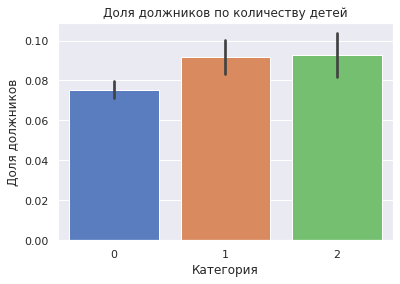

In [50]:
a = sns.barplot(data=df, estimator=np.mean,
            x='children_group', y='debt', palette='muted')
a.set(xlabel='Категория', ylabel='Доля должников', title='Доля должников по количеству детей')
plt.show()

Выведем средний процент должников из переменной `total_debt`

In [51]:
total_debt

0.08115036822970076

Как мы видим из графика, зависимость между наличием детей и возвратом кредита в срок есть. 
Люди без детей чаще возвращают деньги в срок, процент должников в этой группе почти на 0,6% меньше среднего показателя. Показатели заявителей с детьми превышают среднюю на 1% и более.
Общая тенденция - увеличение должников пропорционально увеличению числа детей в семье, однако так как распределение было далеко от равного, я сомневаюсь в достоверности этого вывода.

### Зависимость между семейным положением и возвратом кредита в срок

In [52]:
df[['family_status', 'debt']].groupby('family_status').mean()\
.sort_values(by='debt', ascending=True)

,debt
family_status,
вдовец / вдова,0.065693
в разводе,0.071130
женат / замужем,0.075452
гражданский брак,0.093471
не женат / не замужем,0.097509


Можно было бы искать зависимость в покупательской способности этих разных групп, но тогда непонятно почему не женатые люди возвращают деньги в срок реже чем разведённые. Думаю, это тема для отдельного исследования.

Вывод - Между крайними значениями есть разница порядка 3%, это существенная разница и нужно сделать дополнительное исследование чтобы установить зависимости (по полу заявителя, например).

### Зависимость между уровнем дохода и возвратом кредита в срок

Выведем процент должников в каждой из категорий.
Легенда групп по доходам:
- `0`: `20000 - 100000`
- `1`: `100000 - 140000`
- `2`: `140000 -160000`
- `3`: `160000 - 220000`
- `4`: `220000 - 2300000`


In [53]:
df.groupby('income_group')['debt'].agg(['mean']).sort_values(by='income_group')

,mean
income_group,
0,0.079319
1,0.084924
2,0.090040
3,0.081494
4,0.070858


Теперь взглянем на график изменения процента должников в зависимости от категории

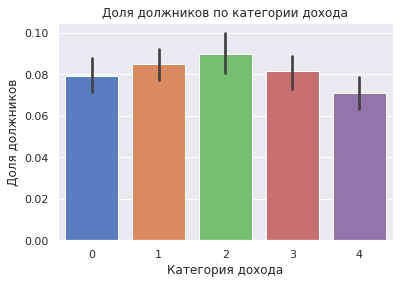

In [54]:
a = sns.barplot(data=df, estimator=np.mean,
            x='income_group', y='debt', palette='muted')
a.set(xlabel='Категория дохода', ylabel='Доля должников', title='Доля должников по категории дохода')
plt.show()

Выведем средний процент должников из переменной `total_debt`

In [55]:
total_debt

0.08115036822970076

Видна зависимость на графике. 1, 2 и 3 группы превышают средний процент должников среди заявителей. То есть люди с доходом от 100000 до 220000 в среднем чаще просрачивают выплату кредита чем люди с доходом до 100000 и люди с доходом более 220000.

### Зависимость между целью получения кредита и возвратом кредита в срок

In [56]:
df[['purpose_group', 'debt']].groupby('purpose_group').mean().sort_values(by='debt', ascending=True)

,debt
purpose_group,
жилье/недвижимость,0.072334
свадьба,0.080034
образование,0.092200
автомобиль,0.093590


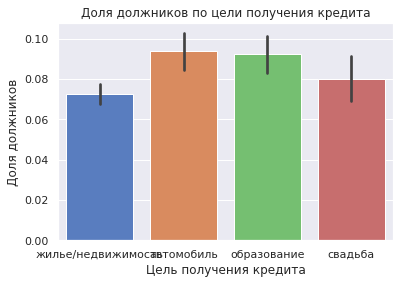

In [57]:
a = sns.barplot(data=df, estimator=np.mean,
            x='purpose_group', y='debt', palette='muted')
a.set(xlabel='Цель получения кредита', ylabel='Доля должников', 
      title='Доля должников по цели получения кредита')
plt.show()

Зависимость определённо есть. Мы видим что реже всего просрачивают выплату люди, покупающие жильё или другую недвижимость. Возможно, так происходит потому что эта самая недвижимость выступает залогом. Больше всего должников в категории людей которые берут кредит на покупку или другие операции с автомобилем.

## Общий вывод

В результате исследования мы нашли зависимость возврата денег в срок от трёх из чертырёх факторов:
- **Дети.** Несмотря на сомнительность вывода из-за неравного рапределения групп мы можем заключить, что общая тенденция - увеличение должников пропорционально увеличению числа детей в семье.
- **Семейное положение.** Да, для разных групп здесь разный процент должников, но зависимостей в рамках этого исследования не видно, нужно делать отдельное чтобы выявить зависимости.
- **Деньги.** Построенный график показал, что люди со средним доходом для нашей группы (100000 - 220000) реже других возвращают кредит в срок.
- **Цели получения кредита.** Люди с целью операций с недвижимостью самый надёжный заёмщик, из них 92.8% возвращают деньги в срок, а вот среди берущих кредит на операции с автомобилями надёжными являются только 90.6%.